In [2]:
import librosa
import librosa.display
import os
import pickle
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
import statistics

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

## Removing Duplicates

In [3]:
def remove_duplicates(name):
    files = os.listdir('dataset/train/'+name)
    regex = re.compile(r'\(.\)')
    delete = filter(regex.search, files)
    count = 0
    for file in delete:
        os.remove('dataset/train/'+name+'/'+file)
        count += 1
    print('Deleted ' + str(count) + ' Files')

In [3]:
emotions = ['disgust', 'fear', 'happy', 'neutral', 'sad']

In [5]:
for emotion in emotions:
    remove_duplicates(emotion)

Deleted 0 Files
Deleted 0 Files
Deleted 0 Files
Deleted 0 Files
Deleted 0 Files


## Loading Paths

In [6]:
paths = []
names = []
for emotion in emotions:
    audios = os.listdir('dataset/train/'+emotion)
    for audio in audios:
        paths.append('dataset/train/'+emotion+'/'+audio)
        names.append(emotion)

{'neutral': 3236, 'happy': 1584, 'sad': 689, 'disgust': 226, 'fear': 210}


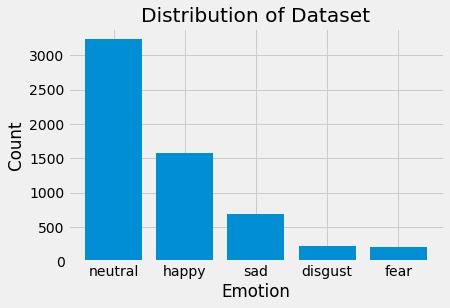

In [7]:
counts = dict(pd.DataFrame(names, columns=['names'])['names'].value_counts())
print(counts)
x = list(counts.keys())
y = list(counts.values())
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Dataset')
plt.xticks(x_pos, x)
plt.show()

## Audio Length Analysis

Minimum length is  0.064
Maximum length is  235.072
Average length is  3.2195068439865335


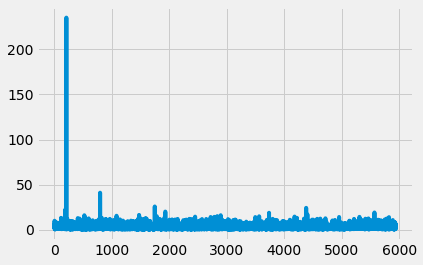

In [8]:
lengths = []
for index,path in enumerate(paths):
    length = librosa.get_duration(filename=path)
    lengths.append(length)
print("Minimum length is ", min(lengths))
print("Maximum length is ", max(lengths))
print("Average length is ", sum(lengths)/len(lengths))
plt.plot(lengths)

## Oversampling Methods

In [9]:
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [10]:
ref = pd.DataFrame(names, columns=['label'])
ref = pd.concat([ref, pd.DataFrame(paths, columns=['path'])], axis=1)
ref.head()

,label,path
0,disgust,dataset/train/disgust/MEL_dia415_utt0_negative...
1,disgust,dataset/train/disgust/MEL_dia231_utt10_negativ...
2,disgust,dataset/train/disgust/MEL_dia169_utt18_negativ...
3,disgust,dataset/train/disgust/MEL_dia754_utt1_negative...
4,disgust,dataset/train/disgust/MEL_dia151_utt0_negative...


## Loading audios

In [11]:
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
count = 0
count_aug = 0

for i in tqdm(ref['path']):
    
    X, sample_rate = librosa.load(i,res_type='kaiser_fast',duration=3,sr=44100)
    mfccs = librosa.feature.mfcc(y=X,sr=np.array(sample_rate),n_mfcc=40)
    df.loc[count] = [mfccs]
    count += 1
    
    if i.split('/')[2] == 'disgust' or i.split('/')[2] == 'fear':
        aug = noise(X)
        aug = librosa.feature.mfcc(y=aug,sr=np.array(sample_rate),n_mfcc=40)
        df_noise.loc[count_aug] = [aug]

        aug = speedNpitch(X)
        aug = librosa.feature.mfcc(y=aug,sr=np.array(sample_rate),n_mfcc=40)
        df_speedpitch.loc[count_aug] = [aug]
        
        count_aug += 1

df.head()

100%|██████████| 5945/5945 [04:27<00:00, 22.19it/s]


,feature
0,"[[-417.4869, -413.6106, -430.1996, -429.12302,..."
1,"[[-371.95184, -343.921, -326.92365, -325.278, ..."
2,"[[-391.9377, -388.76147, -394.02692, -392.722,..."
3,"[[-405.54645, -414.63672, -445.83954, -461.256..."
4,"[[-318.9721, -306.02826, -300.6987, -298.10867..."


In [12]:
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())], axis=1)
df_noise = pd.concat([ref[0:counts['disgust']+counts['fear']],pd.DataFrame(df_noise['feature'].values.tolist())], axis=1)
df_speedpitch = pd.concat([ref[0:counts['disgust']+counts['fear']],pd.DataFrame(df_speedpitch['feature'].values.tolist())], axis=1)
print(df.shape, df_noise.shape, df_speedpitch.shape)

(5945, 3) (436, 3) (436, 3)


In [13]:
df = pd.concat([df, df_noise, df_speedpitch], axis=0, sort=False)
df = df.fillna(0)
del df_noise, df_speedpitch
df.head()

,label,path,0
0,disgust,dataset/train/disgust/MEL_dia415_utt0_negative...,"[[-417.4869, -413.6106, -430.1996, -429.12302,..."
1,disgust,dataset/train/disgust/MEL_dia231_utt10_negativ...,"[[-371.95184, -343.921, -326.92365, -325.278, ..."
2,disgust,dataset/train/disgust/MEL_dia169_utt18_negativ...,"[[-391.9377, -388.76147, -394.02692, -392.722,..."
3,disgust,dataset/train/disgust/MEL_dia754_utt1_negative...,"[[-405.54645, -414.63672, -445.83954, -461.256..."
4,disgust,dataset/train/disgust/MEL_dia151_utt0_negative...,"[[-318.9721, -306.02826, -300.6987, -298.10867..."


## Undersampling Data

In [14]:
n_samples = 600
df_neutral = df[df['label']=='neutral'].sample(n_samples, axis=0, random_state=0)
df_happy = df[df['label']=='happy'].sample(n_samples, axis=0, random_state=0)
df_sad = df[df['label']=='sad'].sample(n_samples, axis=0, random_state=0)
df_disgust = df[df['label']=='disgust'].sample(n_samples, axis=0, random_state=0)
df_fear = df[df['label']=='fear'].sample(n_samples, axis=0, random_state=0)

In [15]:
df = pd.concat([df_neutral, df_happy, df_sad, df_disgust, df_fear], axis=0)

In [18]:
df

,label,path,0
4894,neutral,dataset/train/neutral/MEL_dia228_utt6_neutral_...,"[[-491.33453, -486.9187, -492.67535, -495.5220..."
2509,neutral,dataset/train/neutral/MEL_dia1019_utt8_neutral...,"[[-454.96344, -438.71164, -455.3525, -482.8917..."
4379,neutral,dataset/train/neutral/MEL_dia124_utt0_positive...,"[[-373.5035, -369.96216, -365.6, -367.41455, -..."
3251,neutral,dataset/train/neutral/MEL_dia184_utt12_neutral...,"[[-426.92813, -424.30344, -424.10605, -427.595..."
4194,neutral,dataset/train/neutral/MEL_dia305_utt3_neutral_...,"[[-443.35898, -435.41278, -429.14062, -418.772..."
...,...,...,...
254,fear,dataset/train/fear/MEL_dia366_utt13_negative_F...,"[[-527.24286, -521.71606, -516.7107, -508.5131..."
409,fear,dataset/train/fear/MEL_dia177_utt5_negative_FE...,"[[-383.90417, -376.53427, -328.37994, -289.978..."
265,fear,dataset/train/fear/MEL_dia526_utt6_negative_FE...,"[[-320.57706, -317.68335, -318.3097, -321.4113..."
316,fear,dataset/train/fear/MEL_dia953_utt10_negative_F...,"[[-517.8678, -509.38992, -515.5829, -519.87787..."


In [19]:
X = df.drop(['label', 'path'], axis=1)
y = df['label']

In [20]:
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0],)
y = y.reshape(y.shape[0],)

In [21]:
l = []
for x in X:
    l.append(x.shape[1])
max_pad = max(l)
max_pad

259

In [22]:
X_data = []
for x in X:
    new_x = x.copy()
    new_x.resize(new_x.shape[0], max_pad)
    X_data.append(new_x)

In [23]:
X_data = np.array(X_data)

In [24]:
lb = LabelEncoder()
y_data = np_utils.to_categorical(lb.fit_transform(y))

In [25]:
print(X_data.shape)
print(y_data.shape)

(3000, 40, 259)
(3000, 5)


In [26]:
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

In [27]:
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_data, f)

In [28]:
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_data, f)

## Validation Data

In [8]:
val_paths = []
val_names = []
for emotion in emotions:
    audios = os.listdir('dataset/val/'+emotion)
    for audio in audios:
        val_paths.append('dataset/val/'+emotion+'/'+audio)
        val_names.append(emotion)

{'neutral': 441, 'happy': 179, 'sad': 78, 'disgust': 26, 'fear': 25}


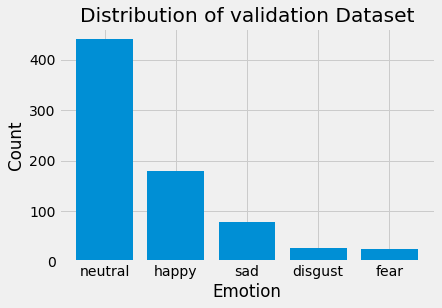

In [9]:
val_counts = dict(pd.DataFrame(val_names, columns=['names'])['names'].value_counts())
print(val_counts)
x = list(val_counts.keys())
y = list(val_counts.values())
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of validation Dataset')
plt.xticks(x_pos, x)
plt.show()

In [10]:
val_ref = pd.DataFrame(val_names, columns=['label'])
val_ref = pd.concat([val_ref, pd.DataFrame(val_paths, columns=['path'])], axis=1)
val_ref.head()

,label,path
0,disgust,dataset/val/disgust/MEL_dia40_utt2_negative_DI...
1,disgust,dataset/val/disgust/MEL_dia92_utt5_negative_DI...
2,disgust,dataset/val/disgust/MEL_dia85_utt4_negative_DI...
3,disgust,dataset/val/disgust/MEL_dia15_utt7_negative_DI...
4,disgust,dataset/val/disgust/MEL_dia23_utt6_negative_DI...


In [12]:
val_df = pd.DataFrame(columns=['feature'])
count = 0

for i in tqdm(val_ref['path']):
    X, sample_rate = librosa.load(i,res_type='kaiser_fast',duration=3,sr=44100)
    mfccs = librosa.feature.mfcc(y=X,sr=np.array(sample_rate),n_mfcc=40)
    val_df.loc[count] = [mfccs]
    count += 1

val_df.head()

100%|██████████| 749/749 [00:48<00:00, 15.43it/s]


,feature
0,"[[-233.58284, -230.39041, -241.17621, -245.626..."
1,"[[-400.9209, -362.0138, -348.6871, -349.9503, ..."
2,"[[-500.8907, -494.97647, -489.19147, -493.8939..."
3,"[[-534.1556, -526.526, -527.9474, -528.0182, -..."
4,"[[-543.0186, -539.8998, -548.6926, -557.4127, ..."


In [14]:
val_df = pd.concat([val_ref,pd.DataFrame(val_df['feature'].values.tolist())], axis=1)
print(val_df.shape)

(749, 3)


In [15]:
X_val = np.array(val_df.drop(['label', 'path'], axis=1))
y_val = np.array(val_df['label'])

X_val = X_val.reshape(X_val.shape[0],)
y_val = y_val.reshape(y_val.shape[0],)

In [17]:
l = []
for x in X_val:
    l.append(x.shape[1])
max_pad = max(l)
max_pad

259

In [18]:
X_data_val = []
for x in X_val:
    new_x = x.copy()
    new_x.resize(new_x.shape[0], max_pad)
    X_data_val.append(new_x)

In [19]:
X_data_val = np.array(X_data_val)

In [23]:
X_data_val.shape

(749, 40, 259)

In [20]:
lb = LabelEncoder()
with open('labels', 'rb') as f:
    lb = pickle.load(f)

In [21]:
y_data_val = np_utils.to_categorical(lb.transform(y_val))

In [22]:
y_data_val.shape

(749, 5)

In [24]:
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_data_val, f)

In [25]:
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_data_val, f)